<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/compare_two_model_by_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 兩個 model 之間對同一張圖片產的 caption 的視覺化和分數比較的小工具

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json,pickle, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm import tqdm
import pickle

## 用來產 generated caption json 檔的 code

In [ ]:
p = open('/content/drive/MyDrive/MSCOCO_2017/new-dataset/output_14x14x512_5000_val.pkl','rb')
val_data = pickle.load(p)

In [ ]:
val_data[0]

In [ ]:
#用file_name反推image_id
def get_imgid(file_name):
  id = ""
  f = 0
  for i in range(12):
    if file_name[i] != "0":
      f = 1
    if f == 1: 
      id += file_name[i]
  return int(id)

In [ ]:
get_imgid('000000700765.jpg')

'700765'

In [ ]:
# 產生所有 val 的 caption 預測結果並輸出成規定格式
# 評分資料格式在 https://cocodataset.org/#format-data 的 5. Image Captioning 大標下有規定
results = list()
for data in tqdm(val_data):  # 多加個 tqdm 是為了看他印出漂亮的進度條
  one_result = dict()
  cap = generate_caption(decoder_model,"",data['feature'],show=False) # 把這裡替換成你用來生 caption 的 function
  one_result["image_id"] = get_imgid(data['filename'])
  one_result["caption"] = cap
  results.append(one_result)

In [ ]:
# 輸出成 json 檔
model_name = os.path.basename(model_path)
save_path = "/content/drive/MyDrive/MSCOCO_2017/score/"
generated_json_path = save_path +"generated_"+ model_name +".json"
print("json saved at", generated_json_path)
with open(generated_json_path, 'w') as jsonfile:
  json.dump(results, jsonfile)

## 評估現存 json 預測結果

In [3]:

if not os.path.exists('coco-caption'):
  # 下載相容 Python3 的非官方套件
  !git clone https://github.com/davidfsemedo/coco-caption
sys.path.insert(0,"/content/coco-caption")
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')


Cloning into 'coco-caption'...
remote: Enumerating objects: 737, done.
remote: Total 737 (delta 0), reused 0 (delta 0), pack-reused 737
Receiving objects: 100% (737/737), 106.72 MiB | 42.67 MiB/s, done.
Resolving deltas: 100% (400/400), done.


In [4]:
answer_json = "/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json"
# 載入第 1 個 model 的預測結果 json 檔
generated_json = "/content/drive/MyDrive/MSCOCO_2017/score/generated_model_noatt_train5000data_1.h5.json"

In [5]:
# 繞過 val2017 和 2014 格式不同的 bug 
# https://github.com/tylin/coco-caption/issues/26#issuecomment-439825144
if (os.path.basename(answer_json) == "captions_val2017.json"):
  modified_anno_path = "/content/modified_captions_val2017.json"
  with open(answer_json, 'r') as f:
    data = json.load(f)
  data['type'] = 'captions'
  with open(modified_anno_path, 'w') as f:
    json.dump(data, f)
  answer_anno_path = modified_anno_path
else:
  answer_anno_path = answer_json

coco = COCO(answer_anno_path)
cocoRes = coco.loadRes(generated_json)

# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
cocoEval.evaluate()

loading annotations into memory...
0:00:00.042825
creating index...
index created!
Loading and preparing results...     
DONE (t=0.57s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 28959, 'reflen': 27184, 'guess': [28959, 26459, 23959, 21459], 'correct': [14706, 5701, 1997, 768]}
ratio: 1.0652957622130272
Bleu_1: 0.508
Bleu_2: 0.331
Bleu_3: 0.209
Bleu_4: 0.134
computing METEOR score...
METEOR: 0.163
computing Rouge score...
ROUGE_L: 0.402
computing CIDEr score...
CIDEr: 0.329


In [6]:
# 載入第 2 個 model 的預測結果 json 檔
generated_json2 = "/content/drive/MyDrive/MSCOCO_2017/score/generated_unkavg_oovrnd_td05_rc02_val_20epoch.h5.json"
cocoRes2 = coco.loadRes(generated_json2)
cocoEval2 = COCOEvalCap(coco, cocoRes2)
cocoEval2.params['image_id'] = cocoRes2.getImgIds()
cocoEval2.evaluate()

Loading and preparing results...     
DONE (t=0.27s)
creating index...
index created!
tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 27052, 'reflen': 25926, 'guess': [27052, 24552, 22052, 19552], 'correct': [14027, 5596, 1933, 692]}
ratio: 1.043431304481947
Bleu_1: 0.519
Bleu_2: 0.344
Bleu_3: 0.218
Bleu_4: 0.138
computing METEOR score...
METEOR: 0.159
computing Rouge score...
ROUGE_L: 0.405
computing CIDEr score...
CIDEr: 0.323


In [8]:
def get_score_by_id(cocoEvalObj, id):
  for one in cocoEvalObj.evalImgs:
    if one['image_id'] == id:
      return one

In [32]:
get_score_by_id(cocoEval, 104612 )
get_score_by_id(cocoEval2, 104612 )

{'Bleu_1': 0.7777777776049386,
 'Bleu_2': 0.7637626156509446,
 'Bleu_3': 0.6933612741860075,
 'Bleu_4': 0.5773502690467204,
 'CIDEr': 0.833989852533696,
 'METEOR': 0.39603292745719104,
 'ROUGE_L': 0.6414300736067298,
 'image_id': 104612}

In [15]:
def show_caption_difference(cocoResObj, cocoRes2Obj, cocoEvalObj, cocoEval2Obj, coco, image_id, compare_score):
  print ('ground truth captions')
  annIds = coco.getAnnIds(imgIds=image_id)
  anns = coco.loadAnns(annIds)
  coco.showAnns(anns)

  score1 = get_score_by_id(cocoEvalObj, image_id)[compare_score]
  print("\nModel 1 generated caption (",compare_score," score %0.2f)"%score1)
  annIds = cocoResObj.getAnnIds(imgIds=image_id)
  anns = cocoResObj.loadAnns(annIds)
  coco.showAnns(anns)

  score2 = get_score_by_id(cocoEval2Obj, image_id)[compare_score]
  print("\nModel 2 generated caption (",compare_score,"score %0.1f)"%score2)
  annIds = cocoRes2Obj.getAnnIds(imgIds=image_id)
  anns = cocoRes2Obj.loadAnns(annIds)
  coco.showAnns(anns)

  img = coco.loadImgs(image_id)[0]
  I = io.imread("/content/drive/MyDrive/MSCOCO_2017/val2017/"+img['file_name'])
  plt.imshow(I)
  plt.axis('off')
  plt.show()

In [61]:
# compare_score 可以 ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4",
# "METEOR", "ROUGE_L", "CIDEr"] 之中挑一種分數來比較
compare_score = 'Bleu_1'

In [62]:
# 隨機抽一張照片來看
rid = np.random.randint(len(cocoRes.getImgIds()))
rimgid = cocoRes.getImgIds()[rid]

In [63]:
# 兩個 model 之間同張圖分數差最多的
maxdiff = 0

for eva in cocoEval.evalImgs:
  imgid1 = eva['image_id']
  challenger = [eva2 for eva2 in cocoEval2.evalImgs if eva2['image_id']==imgid1]
  score1 = eva[compare_score]
  score2 = challenger[0][compare_score]
  if (abs(score2-score1) > maxdiff):
    maxdiff = abs(score2-score1)
    maxdiff_id = imgid1
    print(maxdiff_id, maxdiff)
  
print(maxdiff_id)

37777 0.2833333333447221
522713 0.36666666657851854
171190 0.381755565534231
347265 0.4166666665532409
378605 0.523809523761149
432898 0.6888888887313582
432898


ground truth captions
The man is flying his kite in the sky. 
A man standing on a lush green field under a kite.
A an flying a kite in a field away from parked cars and other flying kites.
Man flying kite in open field near RV park.
A man is bluing a kite in an open area.

Model 1 generated caption ( Bleu_1  score 0.89)
 a man flying a kite in a park <unk>

Model 2 generated caption ( Bleu_1 score 0.2)
 a group of people playing a game of soccer <unk>


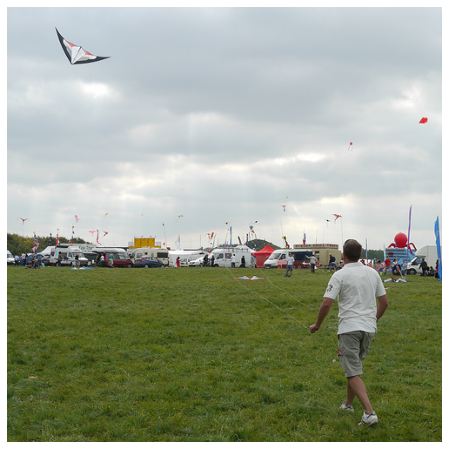

In [64]:
# image_id 可以用 maxdiff_id 或 rimgid 或自己指定數字來玩
show_caption_difference(cocoRes, cocoRes2, cocoEval, cocoEval2, coco, maxdiff_id, compare_score) 

ground truth captions
Grey plane taking off above some green vegetation.
View of jet airliner taking off over tree top.
A passenger jet is flying over some trees.
Aerial view of an airplane ascending in to the sky.
An airplane flying in the sky over some trees.


generated caption (Bleu_1 score 0.1)
 a large clock tower with a clock on it <unk>


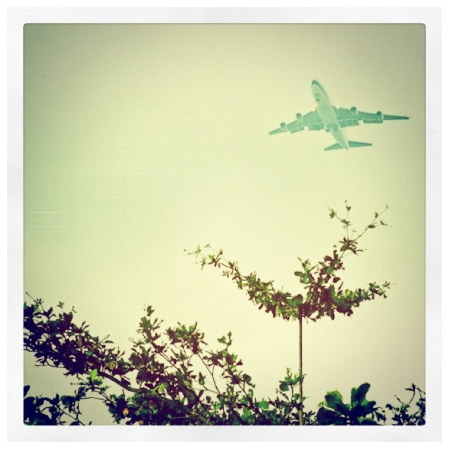

In [ ]:
# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in cocoEval.evalImgs if eva['Bleu_1']<0.1]
print ('ground truth captions')
imgId = evals[0]['image_id']

annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
print ('\n')
print ('generated caption (Bleu_1 score %0.1f)'%(evals[0]['Bleu_1']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread("/content/drive/MyDrive/MSCOCO_2017/val2017/"+img['file_name'])
plt.imshow(I)
plt.axis('off')
plt.show()

In [ ]:
# 評分結果自動彙整進 csv 檔
import csv

scoredict = {'model_name': model_name,
             'train_data': '14x14x512', # '7x7x512' or '14x14x512' or '4096'
             'voc': 'train_voc_5_unk', # 'train_voc_5' or 'train_voc_5_unk'
             'oov_vector': 'random', # 'zero' or 'random'
             'unk_token': 'average', # 'average' or 'none'
             'train_epoch': 92, # 若有 earlystop，填實際上停在第幾 epoch
             'TimeDistributed_dropout': 0.5,
             'recurrent_dropout': 0,
             'predict_data_num': 2500}

fieldnames = ['model_name', 'train_data', 'voc', 'oov_vector', 'unk_token', 
              'train_epoch', 'TimeDistributed_dropout','recurrent_dropout','predict_data_num']
for metric, score in cocoEval.eval.items():
  fieldnames.append(metric)
  scoredict[metric] = score 
  # 還會多存 ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr']
  # 的 column 和分數

score_save_path = save_path + 'integrate_score.csv'
with open(score_save_path, 'a', newline='') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  # writer.writeheader() # 創新檔的時候再跑
  writer.writerow(scoredict)
  csvfile.close()